In [1]:
import os
import netCDF4

import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches

In [2]:
#################
# Load Data
#################
#Path
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
filename_sfc_T2M = 'Feb2020_Attr_sfc-1950-2020_t2m_24H.nc'
filename_sfc_MSL = 'Feb2020_Attr_sfc-1950-2020_msl_24H.nc'
filename_pres_Z = 'Feb2020_Attr_pres-1950-2020_Z500_24H.nc'

#Load netcdf
ncdf_T2M = netCDF4.Dataset(filename_sfc_T2M)
ncdf_MSL = netCDF4.Dataset(filename_sfc_MSL)
ncdf_Z = netCDF4.Dataset(filename_pres_Z)

#Get dimensions
lons = ncdf_T2M.variables['longitude'][:]
lats = ncdf_T2M.variables['latitude'][:]
times = ncdf_T2M.variables['time'][:]

#Calculate datetime
dtimes = np.empty(len(times), dtype='datetime64[h]')
for i,t in enumerate(times):
    dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(np.int64(t),'h')
dtimes = dtimes.astype('datetime64')

#Get variables
t2m = ncdf_T2M.variables['t2m'][:,:,:]-273.15
msl = ncdf_MSL.variables['msl'][:,:,:]/100
z = ncdf_Z.variables['z'][:,:,:]/10

In [3]:
#Calculate mean Tempearture of Dec-Feb 2020 and TClim (mean) of Dec-Feb 1950-2019
dtimes_Clim = dtimes[dtimes < np.datetime64('2019-03-01T00:00')]

TClim_m = np.mean(t2m[np.where(dtimes == np.datetime64('1950-01-01T00:00'))[0][0]:np.where(dtimes == np.datetime64('2019-02-28T00:00'))[0][0]+1,:,:], axis=0)
T2020_m = np.mean(t2m[np.where(dtimes == np.datetime64('2019-12-01T00:00'))[0][0]:np.where(dtimes == np.datetime64('2020-02-28T00:00'))[0][0]+1,:,:], axis=0)
T611Feb_m = np.mean(t2m[np.where(dtimes == np.datetime64('2020-02-06T00:00'))[0][0]:np.where(dtimes == np.datetime64('2020-02-11T00:00'))[0][0]+1,:,:], axis=0)
np.savetxt('T2020_24H.csv', T2020_m, fmt='%.1f', delimiter=';')
np.savetxt('TClim_24H.csv', TClim_m, fmt='%.1f', delimiter=';')
np.savetxt('T611Feb_24H.csv', T611Feb_m, fmt='%.1f', delimiter=';')

MSLClim_m = np.mean(msl[np.where(dtimes == np.datetime64('1950-01-01T00:00'))[0][0]:np.where(dtimes == np.datetime64('2019-02-28T00:00'))[0][0]+1,:,:], axis=0)
MSLClim_std = np.std(msl[np.where(dtimes == np.datetime64('1950-01-01T00:00'))[0][0]:np.where(dtimes == np.datetime64('2019-02-28T00:00'))[0][0]+1,:,:], axis=0)
MSL2020_m = np.mean(msl[np.where(dtimes == np.datetime64('2019-12-01T00:00'))[0][0]:np.where(dtimes == np.datetime64('2020-02-28T00:00'))[0][0]+1,:,:], axis=0)
MSL611Feb_m = np.mean(msl[np.where(dtimes == np.datetime64('2020-02-06T00:00'))[0][0]:np.where(dtimes == np.datetime64('2020-02-11T00:00'))[0][0]+1,:,:], axis=0)
np.savetxt('MSL2020_24H.csv', MSL2020_m, fmt='%.1f', delimiter=';')
np.savetxt('MSLClim_24H.csv', MSLClim_m, fmt='%.1f', delimiter=';')
np.savetxt('MSLClim_24H_std.csv', MSLClim_std, fmt='%.1f', delimiter=';')
np.savetxt('MSL611Feb_24H.csv', MSL611Feb_m, fmt='%.1f', delimiter=';')

Z500Clim_m = np.mean(z[np.where(dtimes == np.datetime64('1950-01-01T00:00'))[0][0]:np.where(dtimes == np.datetime64('2019-02-28T00:00'))[0][0]+1,:,:], axis=0)
Z500Clim_std = np.std(z[np.where(dtimes == np.datetime64('1950-01-01T00:00'))[0][0]:np.where(dtimes == np.datetime64('2019-02-28T00:00'))[0][0]+1,:,:], axis=0)
Z5002020_m = np.mean(z[np.where(dtimes == np.datetime64('2019-12-01T00:00'))[0][0]:np.where(dtimes == np.datetime64('2020-02-28T00:00'))[0][0]+1,:,:], axis=0)
Z500611Feb_m = np.mean(z[np.where(dtimes == np.datetime64('2020-02-06T00:00'))[0][0]:np.where(dtimes == np.datetime64('2020-02-11T00:00'))[0][0]+1,:,:], axis=0)
np.savetxt('Z5002020_24H.csv', Z5002020_m, fmt='%.1f', delimiter=';')
np.savetxt('Z500Clim_24H.csv', Z500Clim_m, fmt='%.1f', delimiter=';')
np.savetxt('Z500Clim_24H_std.csv', Z500Clim_std, fmt='%.1f', delimiter=';')
np.savetxt('Z500611Feb_24H.csv', Z500611Feb_m, fmt='%.1f', delimiter=';')

In [4]:
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')

T2020 = np.loadtxt('T2020_24H.csv', delimiter=';')
TClim = np.loadtxt('TClim_24H.csv', delimiter=';')
T611Feb = np.loadtxt('T611Feb_24H.csv', delimiter=';')

Z5002020 = np.loadtxt('Z5002020_24H.csv', delimiter=';')
Z500Clim = np.loadtxt('Z500Clim_24H.csv', delimiter=';')
Z500611Feb = np.loadtxt('Z500611Feb_24H.csv', delimiter=';')

In [5]:
#######################################################
#Calculate the percentile of 6 day temperature from 1950-to-2019 and compare with 2020
#######################################################
#Load data
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
T2020 = np.loadtxt('T2020_24H.csv', delimiter=';')
TClim = np.loadtxt('TClim_24H.csv', delimiter=';')
T611Feb = np.loadtxt('T611Feb_24H.csv', delimiter=';')

#Calculate mean Tempearture of Feb 2020 and TClim (mean) of Feb 1950-2019
dtimes_Clim = dtimes[dtimes < np.datetime64('2019-03-01T00:00')]

#Calculate the mean of 6 running day temperature from 1950 to 2019
T2m_6day_mean = np.empty((np.size(dtimes_Clim-6), np.size(t2m,1), np.size(t2m,2)))
for i in range(np.size(dtimes_Clim-6)):
    T2m_6day_mean[i,:,:] = np.mean(t2m[i:i+6,:,:], axis=0)

#Calculate and save the percentile
T2m611Feb_percentile = np.empty((np.size(T2m_6day_mean, 1),np.size(T2m_6day_mean, 2)))
for i in range(np.size(T2m_6day_mean, 1)):
    for j in range(np.size(T2m_6day_mean, 2)):
        T2m611Feb_percentile[i,j] = scipy.stats.percentileofscore(T2m_6day_mean[:,i,j], T611Feb[i,j])
np.savetxt('T2m_611Feb_percentile_24H.csv', T2m611Feb_percentile, fmt='%.1f', delimiter=';')

In [6]:
#######################################################
#Calculate the percentile of 6 day temperature from 1950-to-2019 and compare with 2020
#######################################################
#Load data
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
Z5002020 = np.loadtxt('Z5002020_24H.csv', delimiter=';')
Z500Clim = np.loadtxt('Z500Clim_24H.csv', delimiter=';')
Z500611Feb = np.loadtxt('Z500611Feb_24H.csv', delimiter=';')

#Calculate mean Tempearture of Feb 2020 and TClim (mean) of Feb 1950-2019
dtimes_Clim = dtimes[dtimes < np.datetime64('2019-03-01T00:00')]

#Calculate the mean of 6 running day temperature from 1950 to 2019
Z500_6day_mean = np.empty((np.size(dtimes_Clim-6), np.size(z,1), np.size(z,2)))
for i in range(np.size(dtimes_Clim-6)):
    Z500_6day_mean[i,:,:] = np.mean(z[i:i+6,:,:], axis=0)

#Calculate and save the percentile
Z500611Feb_percentile = np.empty((np.size(Z500_6day_mean, 1),np.size(Z500_6day_mean, 2)))
for i in range(np.size(Z500_6day_mean, 1)):
    for j in range(np.size(Z500_6day_mean, 2)):
        Z500611Feb_percentile[i,j] = scipy.stats.percentileofscore(Z500_6day_mean[:,i,j], Z500611Feb[i,j])
np.savetxt('Z500_611Feb_percentile_24H.csv', Z500611Feb_percentile, fmt='%.1f', delimiter=';')

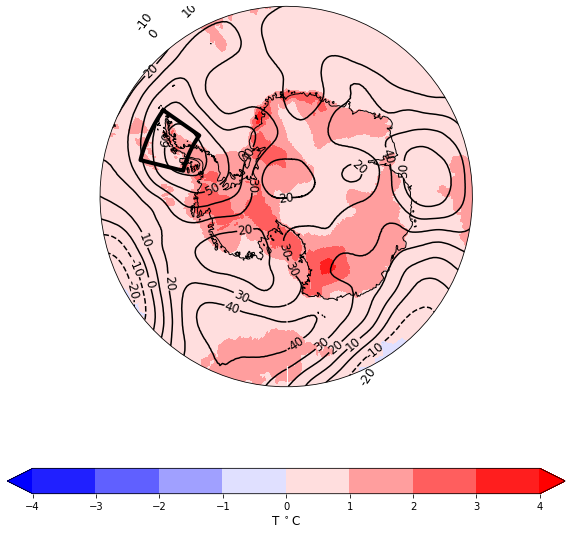

In [7]:
####################
##Plot Feb 2020 Anomalies
####################
#Load data
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
T2M611Feb_percentile = np.loadtxt('T2m_611Feb_percentile_24H.csv', delimiter=';')
Z500611Feb_percentile = np.loadtxt('Z500_611Feb_percentile_24H.csv', delimiter=';')
T2020 = np.loadtxt('T2020_24H.csv', delimiter=';')
TClim = np.loadtxt('TClim_24H.csv', delimiter=';')
T611Feb = np.loadtxt('T611Feb_24H.csv', delimiter=';')
Z5002020 = np.loadtxt('Z5002020_24H.csv', delimiter=';')
Z500Clim = np.loadtxt('Z500Clim_24H.csv', delimiter=';')
Z500611Feb = np.loadtxt('Z500611Feb_24H.csv', delimiter=';')

#Define map
#Map parameters
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=0))
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines(resolution='50m')
#ax.set_title(dtimes[i])
#ax.gridlines(draw_labels=True, linewidth=2, color='white', alpha=1, linestyle='-')

#Plot ERA5
CS1 = ax.contour(lons, lats, (Z5002020-Z500Clim), np.arange(-300,300,10), colors='k', transform=ccrs.PlateCarree())
CS2 = ax.contourf(lons, lats, T2020-TClim, np.arange(-4,4.5,1), cmap='bwr', transform=ccrs.PlateCarree(), extend='both')

#Area selected
rec_lons = [-55, -76]
rec_lats = [-62, -70]
rec_lons_array = np.concatenate([np.linspace(rec_lons[0], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[0], 50), np.linspace(rec_lons[0], rec_lons[0], 50)])
rec_lats_array = np.concatenate([np.linspace(rec_lats[0], rec_lats[0], 50), np.linspace(rec_lats[0], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[0], 50)])
ax.plot(rec_lons_array, rec_lats_array, '-', color='k', linewidth=4, transform=ccrs.PlateCarree())

#Set Parameters
ax.clabel(CS1, inline=1, fontsize=12, fmt='%1.0f')
cb = plt.colorbar(CS2, orientation='horizontal')
cb.set_label('T $^\circ$C', rotation=0, fontsize=12)

#Saveplot
plt.savefig('ERA5_T2manomaly_Feb_2020-clim_24H.png')
#plt.close()

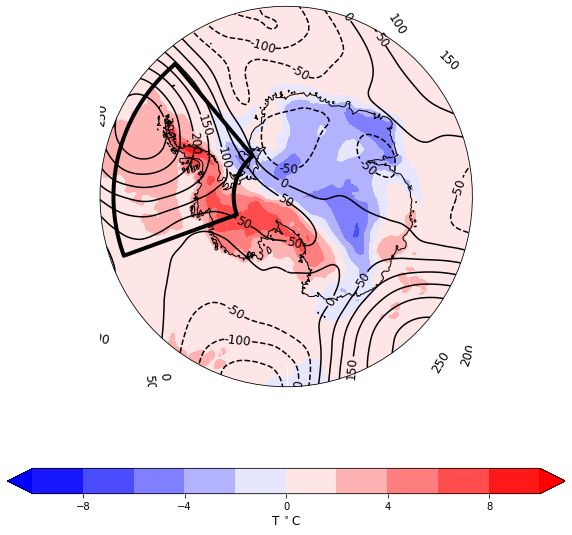

In [8]:
####################
##Plot 5-10 Feb 2020 Anomalies
####################
#Load data
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
T2M611Feb_percentile = np.loadtxt('T2m_611Feb_percentile_24H.csv', delimiter=';')
Z500611Feb_percentile = np.loadtxt('Z500_611Feb_percentile_24H.csv', delimiter=';')
T2020 = np.loadtxt('T2020_24H.csv', delimiter=';')
TClim = np.loadtxt('TClim_24H.csv', delimiter=';')
T611Feb = np.loadtxt('T611Feb_24H.csv', delimiter=';')
Z5002020 = np.loadtxt('Z5002020_24H.csv', delimiter=';')
Z500Clim = np.loadtxt('Z500Clim_24H.csv', delimiter=';')
Z500611Feb = np.loadtxt('Z500611Feb_24H.csv', delimiter=';')

#Define map
#Map parameters
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=0))
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines(resolution='50m')

#Plot ERA5
CS1 = ax.contour(lons, lats, (Z500611Feb-Z500Clim), np.arange(-400,400,50), colors='k', transform=ccrs.PlateCarree())
CS2 = ax.contourf(lons, lats, T611Feb-TClim, np.arange(-10,10.5,2), cmap='bwr', transform=ccrs.PlateCarree(), extend='both')

#Area selected
rec_lons = [-40, -110]
rec_lats = [-58, -80]
rec_lons_array = np.concatenate([np.linspace(rec_lons[0], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[0], 50), np.linspace(rec_lons[0], rec_lons[0], 50)])
rec_lats_array = np.concatenate([np.linspace(rec_lats[0], rec_lats[0], 50), np.linspace(rec_lats[0], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[0], 50)])
ax.plot(rec_lons_array, rec_lats_array, '-', color='k', linewidth=4, transform=ccrs.PlateCarree())

#Set Parameters
ax.clabel(CS1, inline=1, fontsize=12, fmt='%1.0f')
cb = plt.colorbar(CS2, orientation='horizontal')
cb.set_label('T $^\circ$C', rotation=0, fontsize=12)

#Saveplot
plt.savefig('ERA5_T2manomaly_5-10Feb_2020-clim_24H.png')


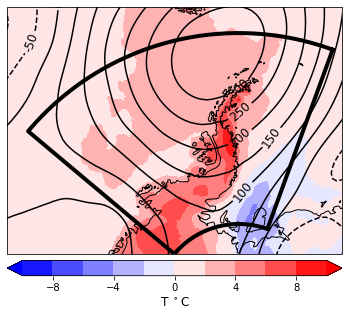

In [12]:
####################
##Plot 5-10 Feb 2020 Anomalies
####################
#Load data
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
T2M611Feb_percentile = np.loadtxt('T2m_611Feb_percentile_24H.csv', delimiter=';')
Z500611Feb_percentile = np.loadtxt('Z500_611Feb_percentile_24H.csv', delimiter=';')
T2020 = np.loadtxt('T2020_24H.csv', delimiter=';')
TClim = np.loadtxt('TClim_24H.csv', delimiter=';')
T611Feb = np.loadtxt('T611Feb_24H.csv', delimiter=';')
Z5002020 = np.loadtxt('Z5002020_24H.csv', delimiter=';')
Z500Clim = np.loadtxt('Z500Clim_24H.csv', delimiter=';')
Z500611Feb = np.loadtxt('Z500611Feb_24H.csv', delimiter=';')

#Define map
#Map parameters
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=-60))
ax.set_extent([-110, -40, -80, -55], crs=ccrs.PlateCarree())

#Set circle boundary
#theta=np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5,0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts*radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines(resolution='50m')

#Plot ERA5
CS1 = ax.contour(lons, lats, (Z500611Feb-Z500Clim), np.arange(-400,400,50), colors='k', transform=ccrs.PlateCarree())
CS2 = ax.contourf(lons, lats, T611Feb-TClim, np.arange(-10,10.5,2), cmap='bwr', transform=ccrs.PlateCarree(), extend='both')

#Area selected
rec_lons = [-40, -110]
rec_lats = [-58, -80]
rec_lons_array = np.concatenate([np.linspace(rec_lons[0], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[0], 50), np.linspace(rec_lons[0], rec_lons[0], 50)])
rec_lats_array = np.concatenate([np.linspace(rec_lats[0], rec_lats[0], 50), np.linspace(rec_lats[0], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[0], 50)])
ax.plot(rec_lons_array, rec_lats_array, '-', color='k', linewidth=4, transform=ccrs.PlateCarree())

#Set Parameters
ax.clabel(CS1, inline=1, fontsize=12, fmt='%1.0f')
cb = plt.colorbar(CS2, orientation='horizontal', pad=0.02)
cb.set_label('T $^\circ$C', rotation=0, fontsize=12)

#Saveplot
plt.savefig('ERA5_T2manomaly_5-10Feb_2020-clim_24H_Reg.png')


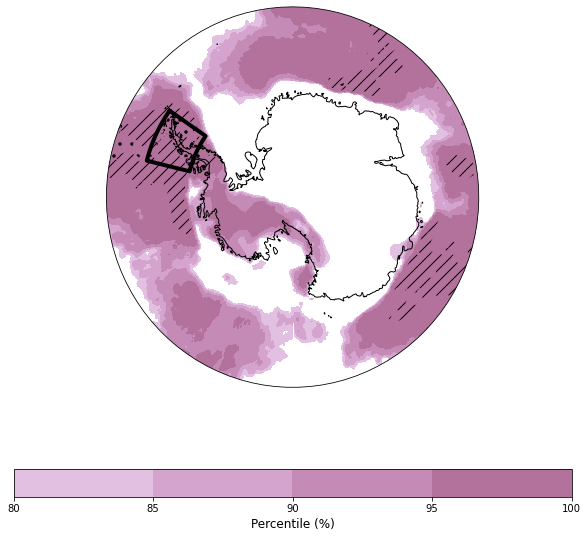

In [13]:
####################
##Plot Feb 2020 Anomalies
####################
#Load data
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
T2M611Feb_percentile = np.loadtxt('T2m_611Feb_percentile_24H.csv', delimiter=';')
Z500611Feb_percentile = np.loadtxt('Z500_611Feb_percentile_24H.csv', delimiter=';')
T2020 = np.loadtxt('T2020_24H.csv', delimiter=';')
TClim = np.loadtxt('TClim_24H.csv', delimiter=';')
T611Feb = np.loadtxt('T611Feb_24H.csv', delimiter=';')
Z5002020 = np.loadtxt('Z5002020_24H.csv', delimiter=';')
Z500Clim = np.loadtxt('Z500Clim_24H.csv', delimiter=';')
Z500611Feb = np.loadtxt('Z500611Feb_24H.csv', delimiter=';')

#Define map
#Map parameters
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=0))
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


ax.coastlines(resolution='50m')

#Plot ERA5
cmap = sns.cubehelix_palette(start=0.9, rot=-.2, dark=0.5, as_cmap=True)
CS2 = ax.contourf(lons, lats, T2M611Feb_percentile, np.arange(80,101,5), cmap=cmap, transform=ccrs.PlateCarree(), extend='neither')
CS3 = ax.contourf(lons, lats, T2M611Feb_percentile, [0,99,99.99,104], hatches=[None, '//', '.'], colors='none', extend='neither', alpha=0, transform=ccrs.PlateCarree())

#Area selected
rec_lons = [-55, -76]
rec_lats = [-62, -70]
rec_lons_array = np.concatenate([np.linspace(rec_lons[0], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[0], 50), np.linspace(rec_lons[0], rec_lons[0], 50)])
rec_lats_array = np.concatenate([np.linspace(rec_lats[0], rec_lats[0], 50), np.linspace(rec_lats[0], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[0], 50)])
ax.plot(rec_lons_array, rec_lats_array, '-', color='k', linewidth=4, transform=ccrs.PlateCarree())


#Set Parameters
cb = plt.colorbar(CS2, orientation='horizontal')
cb.set_label('Percentile (%)', rotation=0, fontsize=12)

#Saveplot
plt.savefig('ERA5_PercentileT2m_5-10Feb_2020-clim_24H.png')

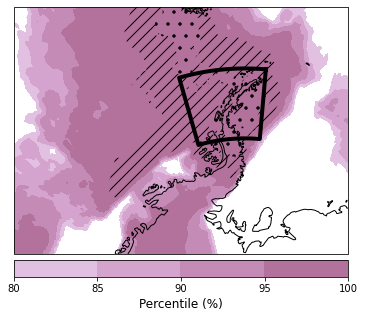

In [14]:
####################
##Plot Feb 2020 Anomalies
####################
#Load data
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
T2M611Feb_percentile = np.loadtxt('T2m_611Feb_percentile_24H.csv', delimiter=';')
Z500611Feb_percentile = np.loadtxt('Z500_611Feb_percentile_24H.csv', delimiter=';')
T2020 = np.loadtxt('T2020_24H.csv', delimiter=';')
TClim = np.loadtxt('TClim_24H.csv', delimiter=';')
T611Feb = np.loadtxt('T611Feb_24H.csv', delimiter=';')
Z5002020 = np.loadtxt('Z5002020_24H.csv', delimiter=';')
Z500Clim = np.loadtxt('Z500Clim_24H.csv', delimiter=';')
Z500611Feb = np.loadtxt('Z500611Feb_24H.csv', delimiter=';')

#Define map
#Map parameters
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=-60))
ax.set_extent([-110, -40, -80, -55], crs=ccrs.PlateCarree())

#Set circle boundary
#theta=np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5,0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts*radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)

ax.coastlines(resolution='50m')

#Plot ERA5
cmap = sns.cubehelix_palette(start=0.9, rot=-.2, dark=0.5, as_cmap=True)
CS2 = ax.contourf(lons, lats, T2M611Feb_percentile, np.arange(80,101,5), cmap=cmap, transform=ccrs.PlateCarree(), extend='neither')
CS3 = ax.contourf(lons, lats, T2M611Feb_percentile, [0,99,99.99,104], hatches=[None, '//', '.'], colors='none', extend='neither', alpha=0, transform=ccrs.PlateCarree())

#Area selected
rec_lons = [-55, -76]
rec_lats = [-62, -70]
rec_lons_array = np.concatenate([np.linspace(rec_lons[0], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[0], 50), np.linspace(rec_lons[0], rec_lons[0], 50)])
rec_lats_array = np.concatenate([np.linspace(rec_lats[0], rec_lats[0], 50), np.linspace(rec_lats[0], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[0], 50)])
ax.plot(rec_lons_array, rec_lats_array, '-', color='k', linewidth=4, transform=ccrs.PlateCarree())


#Set Parameters
cb = plt.colorbar(CS2, orientation='horizontal', pad=0.02)
cb.set_label('Percentile (%)', rotation=0, fontsize=12)

#Saveplot
plt.savefig('ERA5_PercentileT2m_5-10Feb_2020-clim_24H_Reg.png')

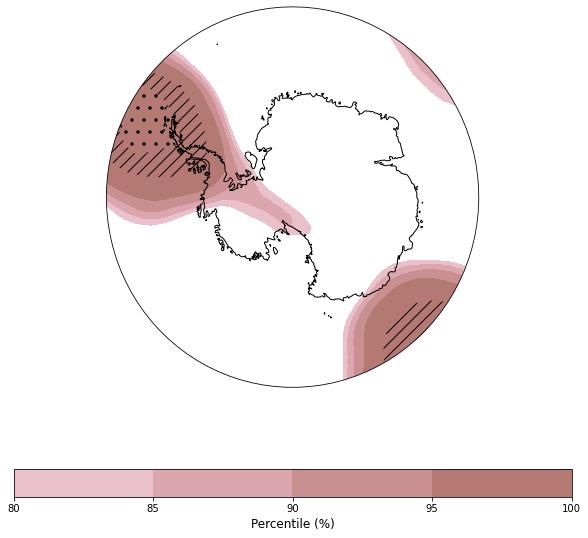

In [15]:
####################
##Plot Feb 2020 Anomalies Z500
####################
#Load data
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
T2M611Feb_percentile = np.loadtxt('T2m_611Feb_percentile_24H.csv', delimiter=';')
Z500611Feb_percentile = np.loadtxt('Z500_611Feb_percentile_24H.csv', delimiter=';')
T2020 = np.loadtxt('T2020_24H.csv', delimiter=';')
TClim = np.loadtxt('TClim_24H.csv', delimiter=';')
T611Feb = np.loadtxt('T611Feb_24H.csv', delimiter=';')
Z5002020 = np.loadtxt('Z5002020_24H.csv', delimiter=';')
Z500Clim = np.loadtxt('Z500Clim_24H.csv', delimiter=';')
Z500611Feb = np.loadtxt('Z500611Feb_24H.csv', delimiter=';')

#Define map
#Map parameters
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=0))
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


ax.coastlines(resolution='50m')

#Plot ERA5
cmap = sns.cubehelix_palette(start=1.3, rot=-.2, dark=0.5, as_cmap=True)
CS2 = ax.contourf(lons, lats, Z500611Feb_percentile, np.arange(80,101,5), cmap=cmap, transform=ccrs.PlateCarree(), extend='neither')
CS3 = ax.contourf(lons, lats, Z500611Feb_percentile, [0,99,99.99,104], hatches=[None, '//', '.'], colors='none', extend='neither', alpha=0, transform=ccrs.PlateCarree())

#Area selected
#rec_lons = [-55, -76]
#rec_lats = [-62, -70]
#rec_lons_array = np.concatenate([np.linspace(rec_lons[0], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[0], 50), np.linspace(rec_lons[0], rec_lons[0], 50)])
#rec_lats_array = np.concatenate([np.linspace(rec_lats[0], rec_lats[0], 50), np.linspace(rec_lats[0], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[0], 50)])
#ax.plot(rec_lons_array, rec_lats_array, '-', color='k', linewidth=4, transform=ccrs.PlateCarree())


#Set Parameters
cb = plt.colorbar(CS2, orientation='horizontal')
cb.set_label('Percentile (%)', rotation=0, fontsize=12)

#Saveplot
plt.savefig('ERA5_PercentileZ500_5-10Feb_2020-clim_24H.png')

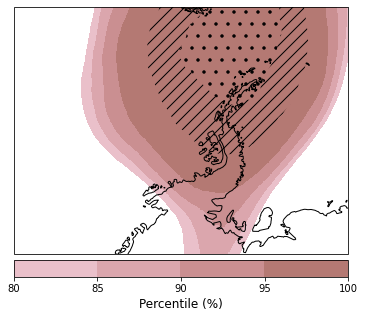

In [17]:
####################
##Plot Feb 2020 Anomalies Z500
####################
#Load data
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
T2M611Feb_percentile = np.loadtxt('T2m_611Feb_percentile_24H.csv', delimiter=';')
Z500611Feb_percentile = np.loadtxt('Z500_611Feb_percentile_24H.csv', delimiter=';')
T2020 = np.loadtxt('T2020_24H.csv', delimiter=';')
TClim = np.loadtxt('TClim_24H.csv', delimiter=';')
T611Feb = np.loadtxt('T611Feb_24H.csv', delimiter=';')
Z5002020 = np.loadtxt('Z5002020_24H.csv', delimiter=';')
Z500Clim = np.loadtxt('Z500Clim_24H.csv', delimiter=';')
Z500611Feb = np.loadtxt('Z500611Feb_24H.csv', delimiter=';')

#Define map
#Map parameters
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=-60))
ax.set_extent([-110, -40, -80, -55], crs=ccrs.PlateCarree())

#Set circle boundary
#theta=np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5,0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts*radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)

ax.coastlines(resolution='50m')

#Plot ERA5
cmap = sns.cubehelix_palette(start=1.3, rot=-.2, dark=0.5, as_cmap=True)
CS2 = ax.contourf(lons, lats, Z500611Feb_percentile, np.arange(80,101,5), cmap=cmap, transform=ccrs.PlateCarree(), extend='neither')
CS3 = ax.contourf(lons, lats, Z500611Feb_percentile, [0,99,99.99,104], hatches=[None, '//', '.'], colors='none', extend='neither', alpha=0, transform=ccrs.PlateCarree())

#Area selected
#rec_lons = [-55, -76]
#rec_lats = [-62, -70]
#rec_lons_array = np.concatenate([np.linspace(rec_lons[0], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[0], 50), np.linspace(rec_lons[0], rec_lons[0], 50)])
#rec_lats_array = np.concatenate([np.linspace(rec_lats[0], rec_lats[0], 50), np.linspace(rec_lats[0], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[0], 50)])
#ax.plot(rec_lons_array, rec_lats_array, '-', color='k', linewidth=4, transform=ccrs.PlateCarree())


#Set Parameters
cb = plt.colorbar(CS2, orientation='horizontal', pad=0.02)
cb.set_label('Percentile (%)', rotation=0, fontsize=12)

#Saveplot
plt.savefig('ERA5_PercentileZ500_5-10Feb_2020-clim_24H_Reg.png')